In [2]:
import numpy as np
import pandas as pd
from data_manager import get_substring, load_metadata
from score import ProbabilityToScore
from columns_desc import columns_dict
from fast_ml.model_development import train_valid_test_split
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from preprocessors import TemporalVariableTransformerDays, TemporalVariableTransformerYears
# from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import plot_importance
import shap
from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
    ROCAUC
)


pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [3]:
df = pd.read_csv('/Users/ronsnir/Documents/postpay/data/behaviour_mature_at_due_df_v2.csv')
df.drop(columns=["customer_date_joined"], inplace=True)

In [4]:
df.shape

(17814, 36)

In [5]:
df.head()

,instalment_plan_id,customer_id,order_id,created,payment_method_brand,payment_method_expires,merchant_name,checkout_type,payment_method_type,user_agent,is_returning,nr_of_items,unpaid_at_due,unpaid_at_5,unpaid_at_10,unpaid_at_20,unpaid_at_30,unpaid_at_60,unpaid_at_90,total_amount,avg_order_value,avg_fees_per_order_30d,avg_fees_per_order_90d,avg_fees_per_order_180d,avg_fees_per_order_365d,count_merchants_per_customer,count_open_orders,count_paid_instalments,count_unpaid_instalments,count_paid_orders,count_unpaid_orders,current_exposure,sum_paid_amount,customer_first_joined,date_of_birth,days_since_last_unpaid
0,4413,2361.0,8436,2021-01-08 15:10:24.680792,mastercard,2024-09-30,The Entertainer,default,credit,Mozilla/5.0 (Linux; Android 10; SM-G960F Build...,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,519.75,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,2021-01-08 15:08:44.970714,1990-10-16,NaN
1,4466,2391.0,8543,2021-01-10 12:09:57.871553,visa,2025-10-31,The Entertainer,default,credit,Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like M...,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,409.50,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,2021-01-10 12:09:00.375030,1988-09-08,NaN
2,4467,2391.0,8547,2021-01-10 12:15:43.086929,visa,2024-04-30,The Entertainer,default,debit,Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like M...,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,309.75,409.5,25.0,25.0,25.0,25.0,1,NaN,2.0,0.0,1.0,NaN,0.0,409.5,2021-01-10 12:09:00.375030,1988-09-08,NaN
3,4469,2393.0,8551,2021-01-10 12:33:42.173393,visa,2022-11-30,The Entertainer,default,credit,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5...,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,309.75,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,2021-01-10 12:31:09.589051,1986-12-06,NaN
4,4492,2408.0,8594,2021-01-11 08:42:29.724145,visa,2022-12-31,The Entertainer,default,debit,Mozilla/5.0 (Linux; Android 9; SM-N950F Build/...,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,414.75,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,2021-01-11 08:38:07.895674,1979-11-14,NaN


In [130]:
df[pd.notnull(df["days_since_last_unpaid"])]

,instalment_plan_id,customer_id,order_id,created,payment_method_brand,payment_method_expires,merchant_name,checkout_type,payment_method_type,user_agent,is_returning,nr_of_items,unpaid_at_due,unpaid_at_5,unpaid_at_10,unpaid_at_20,unpaid_at_30,unpaid_at_60,unpaid_at_90,total_amount,avg_order_value,avg_fees_per_order_30d,avg_fees_per_order_90d,avg_fees_per_order_180d,avg_fees_per_order_365d,count_merchants_per_customer,count_open_orders,count_paid_instalments,count_unpaid_instalments,count_paid_orders,count_unpaid_orders,current_exposure,sum_paid_amount,customer_first_joined,date_of_birth,days_since_last_unpaid
2366,11093,6171.0,21584,2021-04-04 08:47:51.141882,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like...,True,3.0,1261.34,1261.34,1261.34,1261.34,1261.34,1261.34,1261.34,1892.00,1603.166667,36.666667,36.666667,36.666667,36.666667,3,NaN,4.0,2.0,NaN,1.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,192.0
2449,11304,6998.0,21972,2021-04-06 13:51:22.019216,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,False,1.0,606.00,606.00,606.00,606.00,606.00,606.00,606.00,909.00,909.000000,110.000000,110.000000,110.000000,110.000000,1,NaN,0.0,2.0,NaN,1.0,0.0,NaN,2021-04-06 11:58:01.313075,1997-11-07,177.0
2492,11390,6171.0,22189,2021-04-07 14:16:54.562613,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,3.0,1798.00,1798.00,1798.00,1798.00,1798.00,1798.00,1798.00,2697.00,1231.916667,36.666667,36.666667,36.666667,36.666667,6,NaN,8.0,4.0,NaN,2.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,179.0
2493,11391,6171.0,22190,2021-04-07 14:19:36.529124,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,17.0,680.00,680.00,680.00,680.00,680.00,680.00,680.00,1020.00,1441.214286,47.142857,47.142857,47.142857,47.142857,7,NaN,8.0,6.0,NaN,3.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,176.0
2497,11401,6171.0,22206,2021-04-07 15:03:27.197242,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,6.0,3026.00,3026.00,3026.00,3026.00,3026.00,3026.00,3026.00,4539.00,1388.562500,55.000000,55.000000,55.000000,55.000000,8,NaN,8.0,8.0,NaN,4.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,176.0
2499,11404,6171.0,22210,2021-04-07 15:16:41.071783,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,27.0,1510.94,1510.94,1510.94,1510.94,1510.94,1510.94,1510.94,2266.40,1738.611111,61.111111,61.111111,61.111111,61.111111,9,NaN,8.0,10.0,NaN,5.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,176.0
2510,11420,6171.0,22235,2021-04-07 17:20:29.966932,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,25.0,1158.14,1158.14,1158.14,1158.14,1158.14,1158.14,1158.14,1737.20,1791.390000,66.000000,66.000000,66.000000,66.000000,10,NaN,8.0,12.0,NaN,6.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,176.0
3188,12668,7569.0,24577,2021-04-17 15:03:19.701680,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1 Build/H...,True,2.0,32.33,32.33,32.33,32.33,32.33,32.33,32.33,97.00,102.000000,25.500000,25.500000,25.500000,25.500000,1,NaN,1.0,1.0,NaN,1.0,0.0,NaN,2021-04-13 21:59:53.920558,1995-05-26,169.0
3225,12720,7488.0,24669,2021-04-18 00:39:37.509041,mastercard,2026-04-30,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 8.1.0; SM-J415N) A...,True,2.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,300.00,353.000000,27.500000,27.500000,27.500000,27.500000,2,NaN,2.0,1.0,NaN,1.0,0.0,NaN,2021-04-12 15:52:09.130360,1994-03-21,170.0
3269,12802,7282.0,24828,2021-04-18 17:09:22.602365,visa,2024-12-31,Footlocker,default,credit,Mozilla/5.0 (Linux; Android 10; SM-G965F Build...,True,4.0,85.33,85.33,85.33,85.33,85.33,85.33,85.33,256.00,214.200000,53.550000,53.550000,53.550000,53.550000,1,NaN,1.0,1.0,NaN,1.0,0.0,NaN,2021-04-10 00:21:13.655101,1983-05-13,173.0


In [131]:
df[df["customer_id"] == 6171.0]

,instalment_plan_id,customer_id,order_id,created,payment_method_brand,payment_method_expires,merchant_name,checkout_type,payment_method_type,user_agent,is_returning,nr_of_items,unpaid_at_due,unpaid_at_5,unpaid_at_10,unpaid_at_20,unpaid_at_30,unpaid_at_60,unpaid_at_90,total_amount,avg_order_value,avg_fees_per_order_30d,avg_fees_per_order_90d,avg_fees_per_order_180d,avg_fees_per_order_365d,count_merchants_per_customer,count_open_orders,count_paid_instalments,count_unpaid_instalments,count_paid_orders,count_unpaid_orders,current_exposure,sum_paid_amount,customer_first_joined,date_of_birth,days_since_last_unpaid
1986,10067,6171.0,19823,2021-03-22 10:36:06.772810,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like M...,False,9.0,2730.00,2730.00,2730.00,2730.00,2730.00,2730.00,2730.00,4095.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,NaN
2001,10112,6171.0,19901,2021-03-22 20:42:19.962977,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like M...,False,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,455.0,4095.000000,110.000000,110.000000,110.000000,110.000000,1,NaN,0.0,2.0,0.0,NaN,0.0,0.0,2021-03-22 07:12:08.889673,1997-11-07,NaN
2016,10167,6171.0,20000,2021-03-23 21:35:42.896228,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like M...,True,2.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,259.5,2275.000000,55.000000,55.000000,55.000000,55.000000,2,NaN,2.0,2.0,1.0,NaN,0.0,455.0,2021-03-22 07:12:08.889673,1997-11-07,NaN
2366,11093,6171.0,21584,2021-04-04 08:47:51.141882,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like...,True,3.0,1261.34,1261.34,1261.34,1261.34,1261.34,1261.34,1261.34,1892.0,1603.166667,36.666667,36.666667,36.666667,36.666667,3,NaN,4.0,2.0,NaN,1.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,192.0
2451,11306,6171.0,21976,2021-04-06 13:58:14.349328,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,525.0,1675.375000,55.000000,55.000000,55.000000,55.000000,4,NaN,4.0,4.0,2.0,NaN,0.0,714.5,2021-03-22 07:12:08.889673,1997-11-07,NaN
2453,11308,6171.0,21988,2021-04-06 14:35:38.083231,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,165.0,1445.300000,44.000000,44.000000,44.000000,44.000000,5,NaN,6.0,4.0,3.0,NaN,0.0,1239.5,2021-03-22 07:12:08.889673,1997-11-07,NaN
2492,11390,6171.0,22189,2021-04-07 14:16:54.562613,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,3.0,1798.00,1798.00,1798.00,1798.00,1798.00,1798.00,1798.00,2697.0,1231.916667,36.666667,36.666667,36.666667,36.666667,6,NaN,8.0,4.0,NaN,2.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,179.0
2493,11391,6171.0,22190,2021-04-07 14:19:36.529124,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,17.0,680.00,680.00,680.00,680.00,680.00,680.00,680.00,1020.0,1441.214286,47.142857,47.142857,47.142857,47.142857,7,NaN,8.0,6.0,NaN,3.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,176.0
2497,11401,6171.0,22206,2021-04-07 15:03:27.197242,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,6.0,3026.00,3026.00,3026.00,3026.00,3026.00,3026.00,3026.00,4539.0,1388.562500,55.000000,55.000000,55.000000,55.000000,8,NaN,8.0,8.0,NaN,4.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,176.0
2499,11404,6171.0,22210,2021-04-07 15:16:41.071783,visa,2025-12-31,Footlocker,default,debit,Mozilla/5.0 (Linux; Android 9; JKM-LX1) AppleW...,True,27.0,1510.94,1510.94,1510.94,1510.94,1510.94,1510.94,1510.94,2266.4,1738.611111,61.111111,61.111111,61.111111,61.111111,9,NaN,8.0,10.0,NaN,5.0,0.0,NaN,2021-03-22 07:12:08.889673,1997-11-07,176.0


In [6]:
for u in ['unpaid_at_due', 'unpaid_at_5', 'unpaid_at_10', 'unpaid_at_20', 'unpaid_at_30', 'unpaid_at_60', 'unpaid_at_90']:
    mature_df = df[pd.notnull(df[u])]
    print(f"{u}: {(mature_df[u].sum() / mature_df['total_amount'].sum()) * 100}")

unpaid_at_due: 10.729006529617143
unpaid_at_5: 5.067389409679074
unpaid_at_10: 3.695931107174113
unpaid_at_20: 2.4963436373615173
unpaid_at_30: 1.9480353019872592
unpaid_at_60: 1.4724386685465134
unpaid_at_90: 1.0254102911452543


In [7]:
# Drop irrelevant unpaid columns
unpaid_at_30_df = df[pd.notnull(df['unpaid_at_30'])].drop(columns=['unpaid_at_due', 'unpaid_at_5', 'unpaid_at_10', 'unpaid_at_20', 'unpaid_at_60', 'unpaid_at_90'])
# Keep only returning customers (and drop the is_returning column)
returning_df = unpaid_at_30_df[unpaid_at_30_df['is_returning'] == True].drop(columns=['is_returning'])
# Convert unpaid_at_30 to be classifier (1 when unpaid_at_30 is bigger than 0, 0 otherwise)
returning_df['unpaid_at_30'] = np.where(returning_df['unpaid_at_30'] > 0, 1, 0)
# Remove Shopping App orders
browser_df_df = returning_df[~returning_df['checkout_type'].isin(['postpay-card'])]
# Fetch the device type from user_agent variable (and drop the user_agent column)
browser_df_df['user_agent_type'] = browser_df_df['user_agent'].apply(lambda row: get_substring(row, strings_list = ['iPhone', 'Windows NT', 'Macintosh', 'Android'])) # Maybe in the pipeline
browser_df_df.drop(columns=['user_agent'], inplace=True)
returning_unpaid_at_30_df = browser_df_df.copy()

In [8]:
print(f"unpaid_at_30_df: {unpaid_at_30_df.shape}")
print(f"returning_df: {returning_df.shape}")
print(f"browser_df_df: {browser_df_df.shape}")
print(f"returning_unpaid_at_30_df: {returning_unpaid_at_30_df.shape}")

unpaid_at_30_df: (17603, 30)
returning_df: (5889, 29)
browser_df_df: (5762, 29)
returning_unpaid_at_30_df: (5762, 29)


In [9]:
returning_unpaid_at_30_df['unpaid_at_30'].mean()*100

2.5338424158278374

# Start the research

In [10]:
returning_unpaid_at_30_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5762 entries, 84 to 17812
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   instalment_plan_id            5762 non-null   int64  
 1   customer_id                   5762 non-null   float64
 2   order_id                      5762 non-null   int64  
 3   created                       5762 non-null   object 
 4   payment_method_brand          5762 non-null   object 
 5   payment_method_expires        5762 non-null   object 
 6   merchant_name                 5762 non-null   object 
 7   checkout_type                 5762 non-null   object 
 8   payment_method_type           5762 non-null   object 
 9   nr_of_items                   5762 non-null   float64
 10  unpaid_at_30                  5762 non-null   int64  
 11  total_amount                  5762 non-null   float64
 12  avg_order_value               4244 non-null   float64
 13  a

In [11]:
date_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["date"]]
num_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["integer", "numeric"]]
cat_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["categorical"]]
id_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["id"]]

In [12]:
returning_unpaid_at_30_df[date_cols_list] = returning_unpaid_at_30_df[date_cols_list].astype('M')
returning_unpaid_at_30_df[num_cols_list] = returning_unpaid_at_30_df[num_cols_list].astype('f')
returning_unpaid_at_30_df[cat_cols_list] = returning_unpaid_at_30_df[cat_cols_list].astype('O')
# returning_unpaid_at_30_df[date_cols_list] = returning_unpaid_at_30_df[date_cols_list].astype('M')
# https://numpy.org/doc/stable/reference/arrays.dtypes.html

In [13]:
returning_unpaid_at_30_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5762 entries, 84 to 17812
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   instalment_plan_id            5762 non-null   int64         
 1   customer_id                   5762 non-null   float64       
 2   order_id                      5762 non-null   int64         
 3   created                       5762 non-null   datetime64[ns]
 4   payment_method_brand          5762 non-null   object        
 5   payment_method_expires        5762 non-null   datetime64[ns]
 6   merchant_name                 5762 non-null   object        
 7   checkout_type                 5762 non-null   object        
 8   payment_method_type           5762 non-null   object        
 9   nr_of_items                   5762 non-null   float32       
 10  unpaid_at_30                  5762 non-null   float32       
 11  total_amount                

# Analysis

## Target

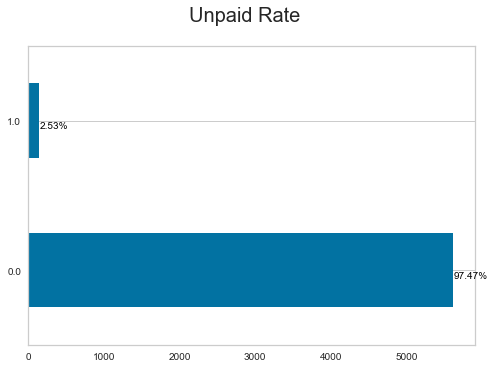

In [14]:
ax = returning_unpaid_at_30_df["unpaid_at_30"].value_counts().plot(kind="barh")
totals = [i.get_width() for i in ax.patches]
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle("Unpaid Rate", fontsize=20)
plt.show()

In [15]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in returning_unpaid_at_30_df.columns if returning_unpaid_at_30_df[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

returning_unpaid_at_30_df[vars_with_na].isnull().mean().sort_values(ascending=False)*100

count_open_orders          99.982645
days_since_last_unpaid     98.750434
count_unpaid_orders        97.743839
avg_fees_per_order_30d     48.889275
avg_fees_per_order_90d     32.228393
avg_fees_per_order_180d    27.039222
avg_order_value            26.345019
avg_fees_per_order_365d    26.345019
date_of_birth               8.035404
count_paid_orders           2.273516
sum_paid_amount             2.273516
user_agent_type             0.329747
dtype: float64

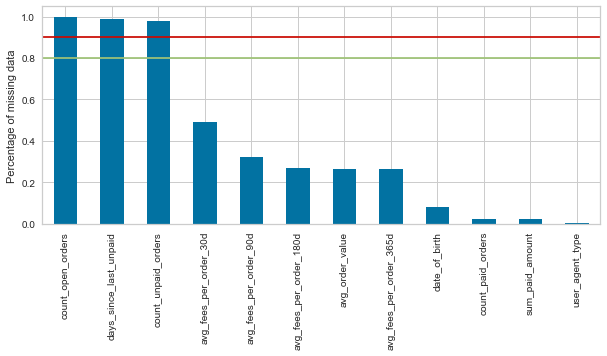

In [16]:
# plot

returning_unpaid_at_30_df[vars_with_na].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel("Percentage of missing data")
plt.axhline(y=0.90, color="r", linestyle="-")
plt.axhline(y=0.80, color="g", linestyle="-")

plt.show()

In [17]:
# now we can determine which variables, from those with missing data,
# are numerical and which are categorical

cat_na = [var for var in cat_cols_list if var in vars_with_na]
num_na = [var for var in num_cols_list if var in vars_with_na]

print("Number of categorical variables with na: ", len(cat_na))
print("Number of numerical variables with na: ", len(num_na))

Number of categorical variables with na:  1
Number of numerical variables with na:  10


In [18]:
cat_na

['user_agent_type']

In [19]:
num_na

['avg_order_value',
 'avg_fees_per_order_365d',
 'avg_fees_per_order_180d',
 'avg_fees_per_order_90d',
 'avg_fees_per_order_30d',
 'count_open_orders',
 'count_paid_orders',
 'count_unpaid_orders',
 'sum_paid_amount',
 'days_since_last_unpaid']

In [20]:
def analyse_na_value(df, var):

    # copy of the dataframe, so that we do not override the original data
    # see the link for more details about pandas.copy()
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html
    df = df.copy()

    # let"s make an interim variable that indicates 1 if the
    # observation was missing or 0 otherwise
    df[var] = np.where(df[var].isnull(), "Null", "Not null")

    # let's compare the median SalePrice in the observations where data is missing
    # vs the observations where data is available

    # determine the median price in the groups 1 and 0,
    # and the standard deviation of the sale price,
    # and we capture the results in a temporary dataset
    tmp = df.groupby(var)["unpaid_at_30"].agg(["mean"])*100
    print(tmp)

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False, title="Unpaid", color="green")

    plt.show()

                     mean
avg_order_value          
Not null         2.403393
Null             2.898551


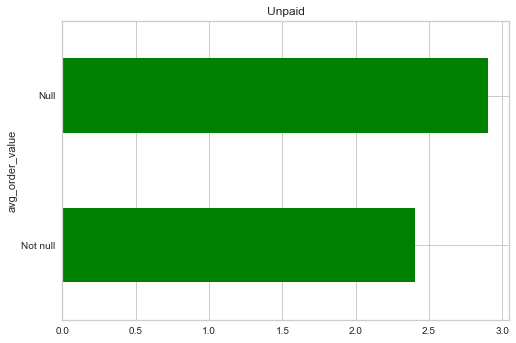

                            mean
avg_fees_per_order_30d          
Not null                2.954160
Null                    2.094427


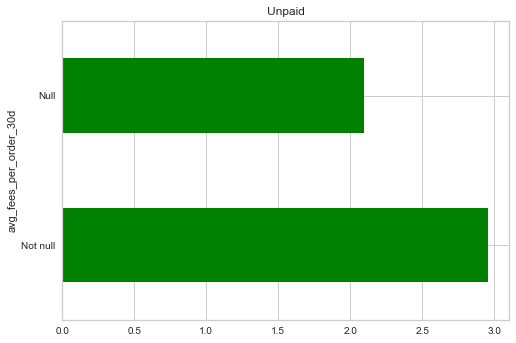

                            mean
avg_fees_per_order_90d          
Not null                2.509603
Null                    2.584814


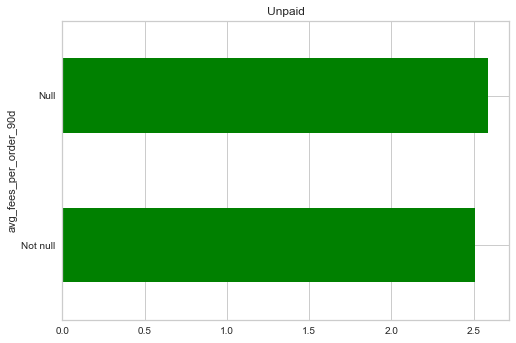

                             mean
avg_fees_per_order_180d          
Not null                 2.426261
Null                     2.824133


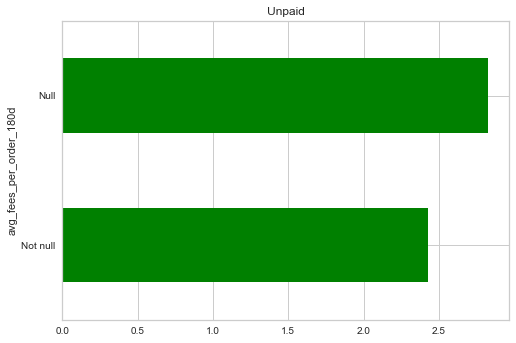

                             mean
avg_fees_per_order_365d          
Not null                 2.403393
Null                     2.898551


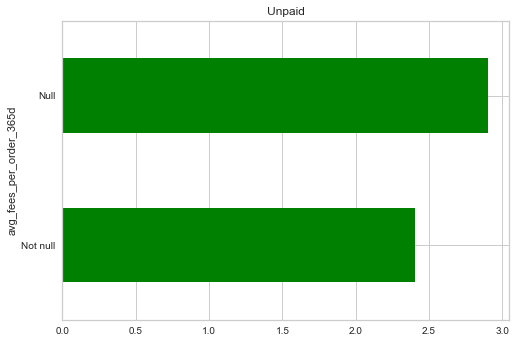

                       mean
count_open_orders          
Not null           0.000000
Null               2.534282


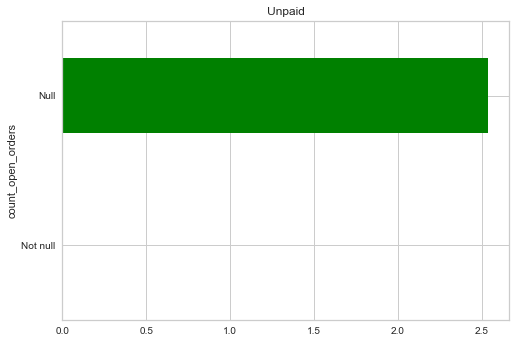

                        mean
count_paid_orders           
Not null            0.284141
Null               99.236641


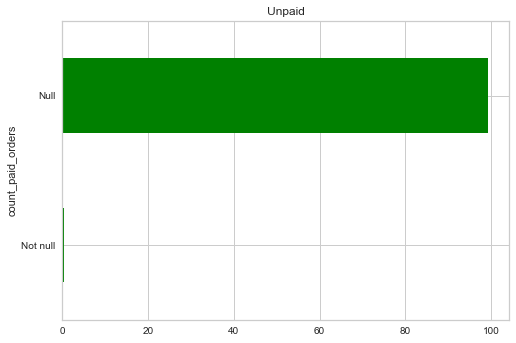

                           mean
count_unpaid_orders            
Not null             100.000000
Null                   0.284091


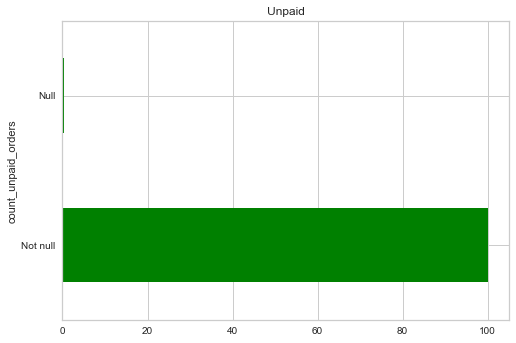

                      mean
sum_paid_amount           
Not null          0.284141
Null             99.236641


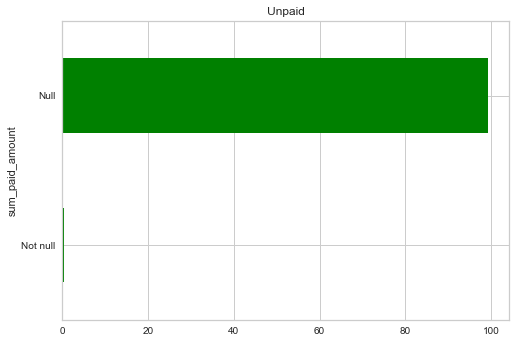

                   mean
date_of_birth          
Not null       2.623137
Null           1.511879


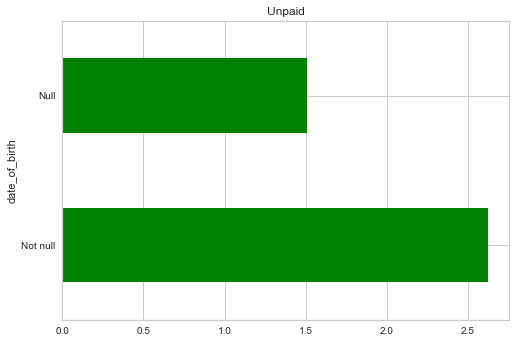

                              mean
days_since_last_unpaid            
Not null                100.000000
Null                      1.300527


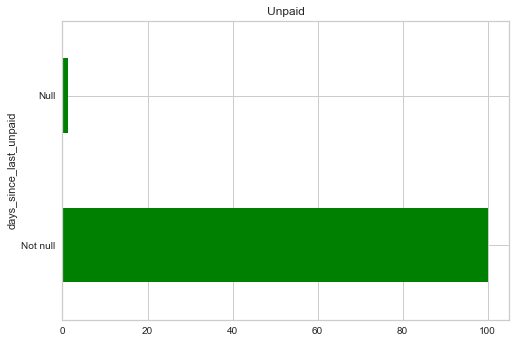

                     mean
user_agent_type          
Not null         2.542225
Null             0.000000


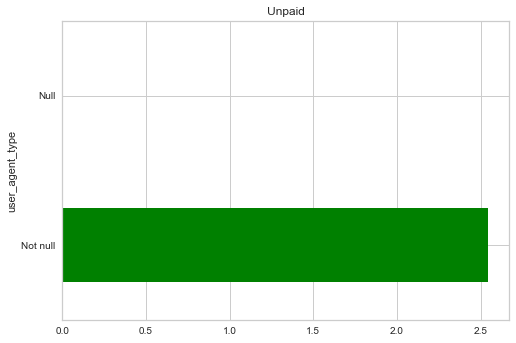

In [21]:
# let's run the function on each variable with missing data

for var in vars_with_na:
    analyse_na_value(returning_unpaid_at_30_df, var)

In [22]:
date_cols_list

['created', 'payment_method_expires', 'customer_first_joined', 'date_of_birth']

In [23]:
#  let's make a list of discrete variables
discrete_vars = [var for var in num_cols_list if len(
    returning_unpaid_at_30_df[var].unique()) < 20]


print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  4


In [24]:
# let's visualise the discrete variables

returning_unpaid_at_30_df[discrete_vars].head()

,unpaid_at_30,count_open_orders,count_unpaid_orders,count_unpaid_instalments
84,0.0,NaN,NaN,0.0
122,0.0,NaN,NaN,0.0
125,0.0,NaN,NaN,0.0
177,0.0,NaN,NaN,0.0
212,0.0,NaN,NaN,0.0


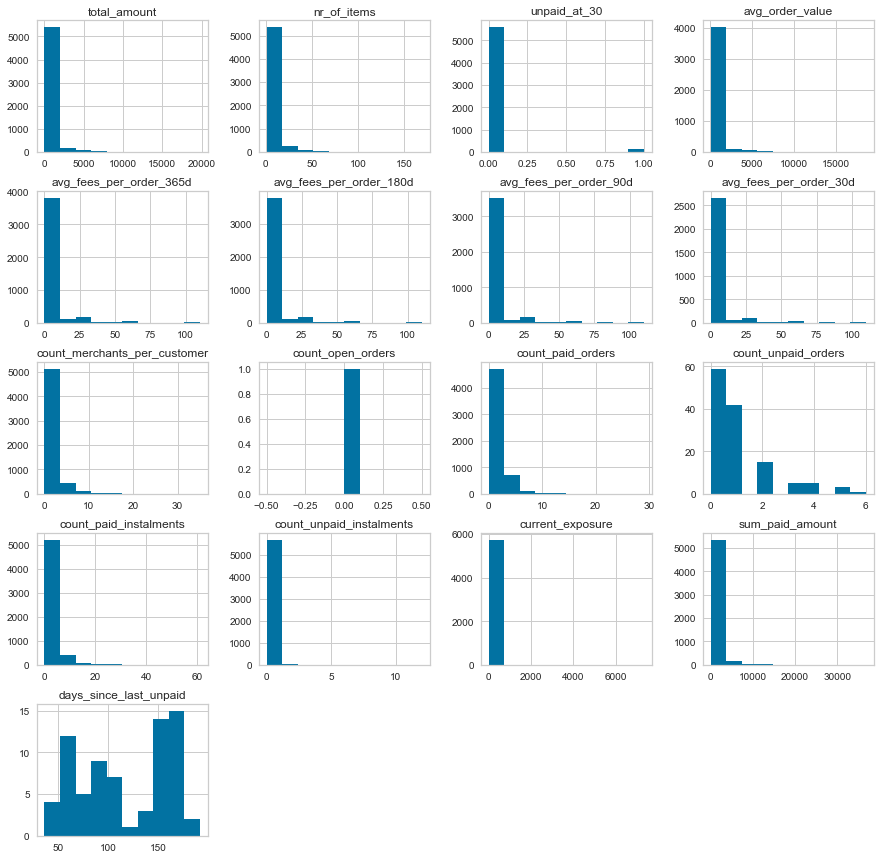

In [25]:
# lets plot histograms for all continuous variables

returning_unpaid_at_30_df[num_cols_list].hist(bins=10, figsize=(15,15))
plt.show()

In [26]:
print('Number of categorical variables: ', len(cat_cols_list))

Number of categorical variables:  5


<AxesSubplot:>

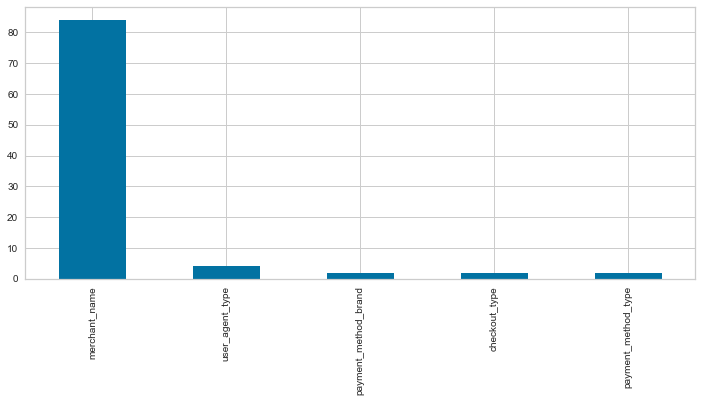

In [27]:
# we count unique categories with pandas nunique() 
# and then plot them in descending order

returning_unpaid_at_30_df[cat_cols_list].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [28]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['unpaid_at_30'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in cat_cols_list:
    print(analyse_rare_labels(returning_unpaid_at_30_df, var, 0.01))
    print()

Series([], Name: unpaid_at_30, dtype: float64)

merchant_name
Abrash Carpets                         0.000694
Adrenaline Travel                      0.000174
Amber Mint                             0.000174
Aqaurist Hub UAE                       0.000174
Asghar Furniture                       0.000347
Blue Ocean Sports                      0.000347
Boco Textile Trading L.L.C             0.000868
Boots                                  0.006768
BrandDose                              0.001388
Business of Preloved Fashion           0.007116
CRYO                                   0.002256
Candle Start                           0.000347
Capital Supply                         0.000694
Combat Sports                          0.000347
DIGG                                   0.000174
Dermalogica                            0.002430
Desert River                           0.001388
E-Scooter UAE Hub                      0.001215
Elivana                                0.000521
Emporium Star General Trad

# Pipeline

In [29]:
# load the metadata
metadata = load_metadata("/Users/ronsnir/Documents/postpay/data/metadata.json")

In [30]:
# Split to train/valid/test
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(
    df=returning_unpaid_at_30_df,
     target=metadata["split_dict"]["target_col"],
     train_size=metadata["split_dict"]["train_size"],
     valid_size=metadata["split_dict"]["valid_size"],
     test_size=metadata["split_dict"]["test_size"],
     method='random',
     sort_by_col=None,
     random_state=101
     )

In [31]:
X_train.shape, X_valid.shape, X_test.shape

((4609, 28), (576, 28), (577, 28))

In [32]:
y_train.mean()*100, y_valid.mean()*100, y_test.mean()*100

(2.6252983137965202, 2.083333395421505, 2.253032848238945)

## Configuration

In [33]:
ArbitraryNumberImputer_0_col_list = [c for c in columns_dict if columns_dict[c]["nulls_method"] in ["ArbitraryNumberImputer_0"]]
CategoricalImputer_Missing_col_list = [c for c in columns_dict if columns_dict[c]["nulls_method"] in ["CategoricalImputer_Missing"]]
days_forward_col_list = [c for c in columns_dict if columns_dict[c]["imputer"] in ["days_forward"]]
days_back_col_list = [c for c in columns_dict if columns_dict[c]["imputer"] in ["days_back"]]
years_back_col_list = [c for c in columns_dict if columns_dict[c]["imputer"] in ["years_back"]]

## Pipe line

In [34]:
# set up the pipeline
pipeline = Pipeline([
    # ===== IMPUTATION =====
    # Impute numerical variables with 0
    ('missing_imputation_num_0', ArbitraryNumberImputer(arbitrary_number=0, variables=ArbitraryNumberImputer_0_col_list)),

    # Impute categorical variables with 'Missing'
    ('missing_imputation_cat', CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=CategoricalImputer_Missing_col_list)),


    # == TEMPORAL VARIABLES ====
    ('days_forward', TemporalVariableTransformerDays(variables=days_forward_col_list, reference_variable="today", variables_first=True)),
    ('days_back', TemporalVariableTransformerDays(variables=days_back_col_list, reference_variable="today", variables_first=False)),
    ('years_back', TemporalVariableTransformerYears(variables=years_back_col_list, reference_variable="today", variables_first=False)),

    ('drop_features', DropFeatures(features_to_drop=date_cols_list+id_cols_list)),

    # == CATEGORICAL ENCODING
    ('one_hot_encoder_frequent', OneHotEncoder(top_categories=10,  # you can change this value to select more or less variables
    # we can select which variables to encode
    variables=cat_cols_list,
    drop_last=False)),

])

In [35]:
# train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation_num_0',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['avg_order_value',
                                                   'avg_fees_per_order_365d',
                                                   'avg_fees_per_order_180d',
                                                   'avg_fees_per_order_90d',
                                                   'avg_fees_per_order_30d',
                                                   'count_open_orders',
                                                   'count_paid_orders',
                                                   'count_unpaid_orders',
                                                   'count_paid_instalments',
                                                   'count_unpaid_instalments',
                                                   'current_exposure',...
                                                  variables=['date_

In [36]:
# transform the data
X_train_transformed = pipeline.transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)
X_test_transformed = pipeline.transform(X_test)

In [37]:
X_train_transformed

,nr_of_items,total_amount,avg_order_value,avg_fees_per_order_30d,avg_fees_per_order_90d,avg_fees_per_order_180d,avg_fees_per_order_365d,count_merchants_per_customer,count_open_orders,count_paid_instalments,count_unpaid_instalments,count_paid_orders,count_unpaid_orders,current_exposure,sum_paid_amount,days_since_last_unpaid,payment_method_expires_days,customer_first_joined_days,date_of_birth_years,payment_method_brand_visa,payment_method_brand_mastercard,merchant_name_Footlocker,merchant_name_Bath and Body Works,merchant_name_The Entertainer,merchant_name_Victoria's Secret,merchant_name_Squat Wolf,merchant_name_H&M,merchant_name_Ounass,merchant_name_Pottery Barn,merchant_name_Marine Hub,merchant_name_American Eagle,checkout_type_default,checkout_type_seamless,payment_method_type_debit,payment_method_type_credit,user_agent_type_iPhone,user_agent_type_Android,user_agent_type_Windows NT,user_agent_type_Macintosh,user_agent_type_Missing
4811,1.0,257.250000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,390,281,33.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0
17375,51.0,969.000000,951.554565,0.0,0.0,0.0,0.0,11.0,0.0,22.0,0.0,11.0,0.0,0.000000,10467.099609,NaN,724,140,27.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0
15554,1.0,304.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,237,85,36.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
7350,3.0,311.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,1698,270,35.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
5717,1.0,215.750000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,1486,294,29.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,1.0,137.000000,223.600006,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.000000,223.600006,NaN,1302,236,29.0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
17599,7.0,119.699997,208.000000,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,1.0,0.0,88.669998,150.000000,NaN,1121,32,NaN,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0
6107,2.0,2496.360107,587.940002,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,2.0,0.0,0.000000,1175.880005,NaN,1364,343,44.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0
6652,1.0,259.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,1517,310,33.0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [38]:
X_train_transformed.isnull().mean()

nr_of_items                          0.000000
total_amount                         0.000000
avg_order_value                      0.000000
avg_fees_per_order_30d               0.000000
avg_fees_per_order_90d               0.000000
avg_fees_per_order_180d              0.000000
avg_fees_per_order_365d              0.000000
count_merchants_per_customer         0.000000
count_open_orders                    0.000000
count_paid_instalments               0.000000
count_unpaid_instalments             0.000000
count_paid_orders                    0.000000
count_unpaid_orders                  0.000000
current_exposure                     0.000000
sum_paid_amount                      0.000000
days_since_last_unpaid               0.986765
payment_method_expires_days          0.000000
customer_first_joined_days           0.000000
date_of_birth_years                  0.080929
payment_method_brand_visa            0.000000
payment_method_brand_mastercard      0.000000
merchant_name_Footlocker          

In [39]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4609 entries, 4811 to 16093
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   nr_of_items                        4609 non-null   float32
 1   total_amount                       4609 non-null   float32
 2   avg_order_value                    4609 non-null   float32
 3   avg_fees_per_order_30d             4609 non-null   float32
 4   avg_fees_per_order_90d             4609 non-null   float32
 5   avg_fees_per_order_180d            4609 non-null   float32
 6   avg_fees_per_order_365d            4609 non-null   float32
 7   count_merchants_per_customer       4609 non-null   float32
 8   count_open_orders                  4609 non-null   float32
 9   count_paid_instalments             4609 non-null   float32
 10  count_unpaid_instalments           4609 non-null   float32
 11  count_paid_orders                  4609 non-null   f

In [40]:
constant_params = {"learning_rate": 0.1, "max_depth": 5, "n_estimators": 500, "random_state": 101, "early_stopping_rounds": 10}
model = xgb.XGBClassifier(**constant_params)

In [41]:
eval_set = [(X_train_transformed, y_train), (X_valid_transformed, y_valid)]
model.fit(X_train_transformed, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

[11:24:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.92515	validation_1-auc:0.89687
[1]	validation_0-auc:0.93024	validation_1-auc:0.89487
[2]	validation_0-auc:0.94147	validation_1-auc:0.90078
[3]	validation_0-auc:0.94147	validation_1-auc:0.90078
[4]	validation_0-auc:0.94147	validation_1-auc:0.90078
[5]	validation_0-auc:0.94753	validation_1-auc:0.89524
[6]	validation_0-auc:0.95224	validation_1-auc:0.89317
[7]	validation_0-auc:0.95357	validation_1-auc:0.89258
[8]	validation_0-auc:0.95439	validation_1-auc:0.89162
[9]	validation_0-auc:0.96071	validation_1-auc:0.88778
[10]	validation_0-auc:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=101, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
model.predict_proba(X_test_transformed)[:,1]

array([9.93310571e-01, 8.89638977e-06, 4.38370480e-05, 1.18936448e-04,
       3.38482423e-05, 4.42505407e-04, 1.32931091e-05, 5.67960160e-05,
       2.88140960e-04, 4.95376935e-06, 7.40167161e-05, 1.31768800e-04,
       5.54736871e-05, 2.15633583e-04, 3.91207024e-04, 2.14291783e-03,
       8.21282640e-02, 8.79350409e-05, 8.13032748e-05, 3.77650190e-06,
       3.33074859e-04, 5.61946945e-04, 3.09458192e-05, 6.24764507e-05,
       1.27431359e-02, 1.37462470e-04, 5.51514604e-05, 3.52375282e-05,
       2.15656000e-05, 1.83702173e-06, 1.36315532e-03, 2.58446707e-05,
       2.11308850e-03, 6.12640360e-05, 8.88416180e-05, 6.19524071e-05,
       2.45399838e-06, 2.68516851e-05, 1.63031855e-05, 9.99260101e-06,
       3.95288313e-04, 4.20834898e-04, 3.68931855e-04, 2.46211712e-04,
       1.74154120e-05, 5.99498708e-06, 7.26649978e-06, 1.11348209e-05,
       2.35729497e-02, 1.26101850e-06, 2.28085046e-04, 9.54756797e-06,
       7.75281689e-04, 3.86843021e-06, 4.57930655e-05, 2.29417463e-04,
      

In [43]:
print('Test set')
print('XGB roc-auc: {}'.format(roc_auc_score(y_test, model.predict_proba(X_test_transformed)[:,1])))

Test set
XGB roc-auc: 0.9642662302236771


In [44]:
from sklearn.metrics import (
    roc_auc_score,
    plot_roc_curve,
)

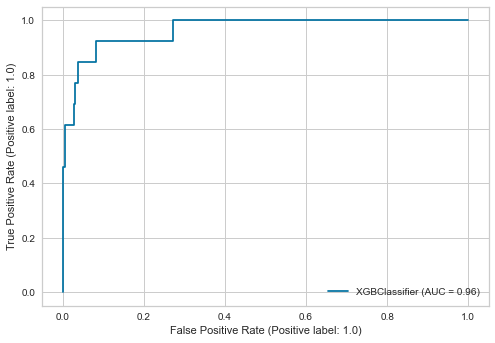

In [45]:
xgb_disp = plot_roc_curve(model, X_test_transformed, y_test)

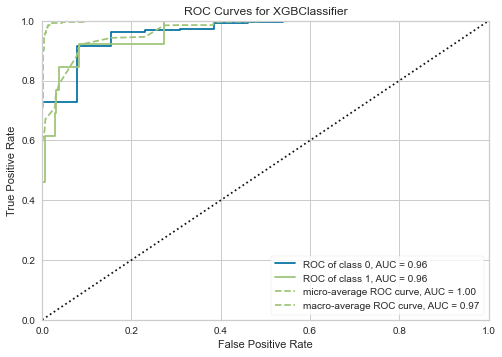

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [46]:
visualizer = ROCAUC(model, classes=[0, 1])

visualizer.fit(X_train_transformed, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [47]:
print(model.feature_importances_)

[0.00540624 0.006556   0.0053758  0.00583592 0.0117719  0.00073117
 0.01179094 0.01885931 0.         0.03208507 0.00136888 0.02767159
 0.         0.06380675 0.02036139 0.6612221  0.00707757 0.00655833
 0.00628836 0.00522916 0.         0.00971356 0.01968442 0.00736121
 0.00781295 0.00522815 0.         0.01136    0.         0.
 0.         0.00895369 0.         0.00568677 0.         0.00547852
 0.0043753  0.00552566 0.01082328 0.        ]


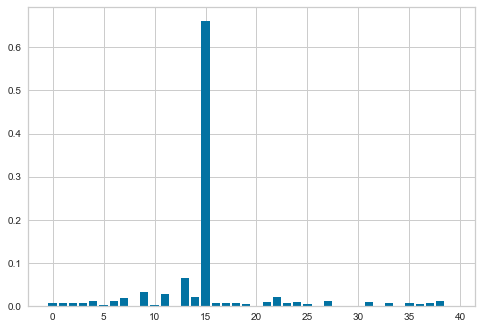

In [48]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

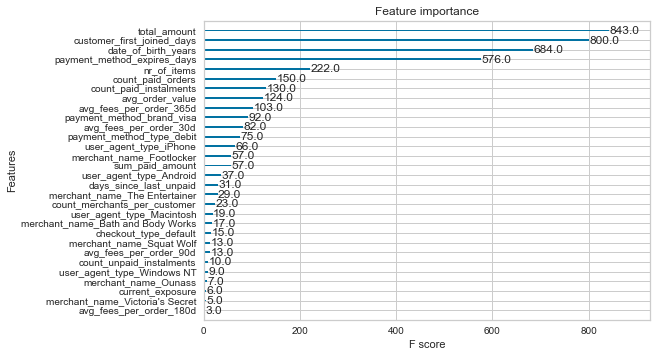

In [49]:
# plot feature importance
from xgboost import plot_importance
plot_importance(model)
plt.show()

<BarContainer object of 40 artists>

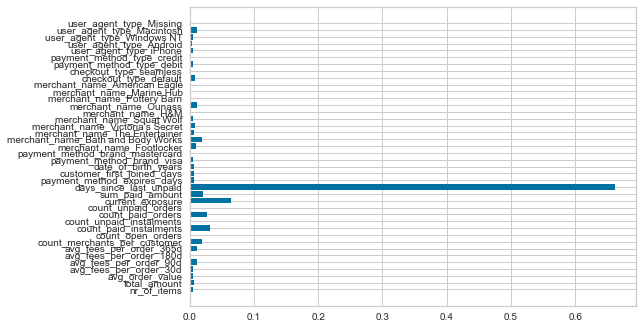

In [50]:
plt.barh(X_test_transformed.columns, model.feature_importances_)

Text(0.5, 0, 'Xgboost Feature Importance')

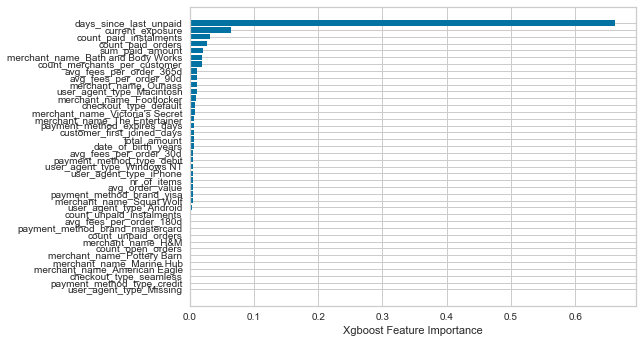

In [51]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_test_transformed.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [52]:
print(model.importance_type)

None


# scikit-learn

In [53]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test_transformed, y_test)

Text(0.5, 0, 'Permutation Importance')

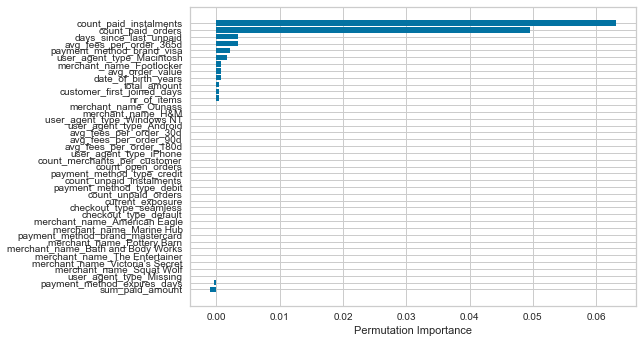

In [54]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test_transformed.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# SHAP

In [55]:
import shap

In [56]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

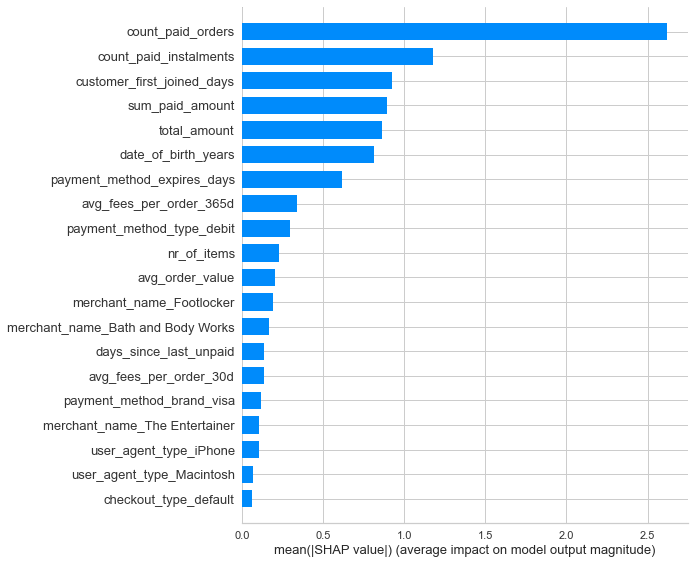

In [57]:
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

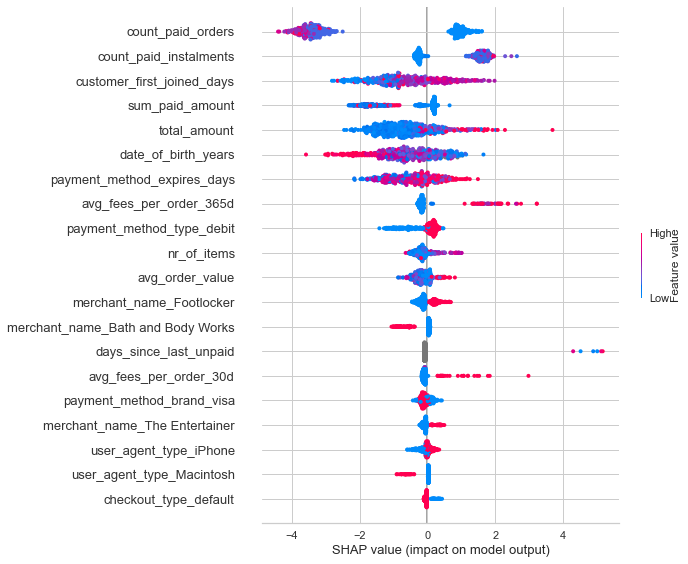

In [58]:
shap.summary_plot(shap_values, X_test_transformed)

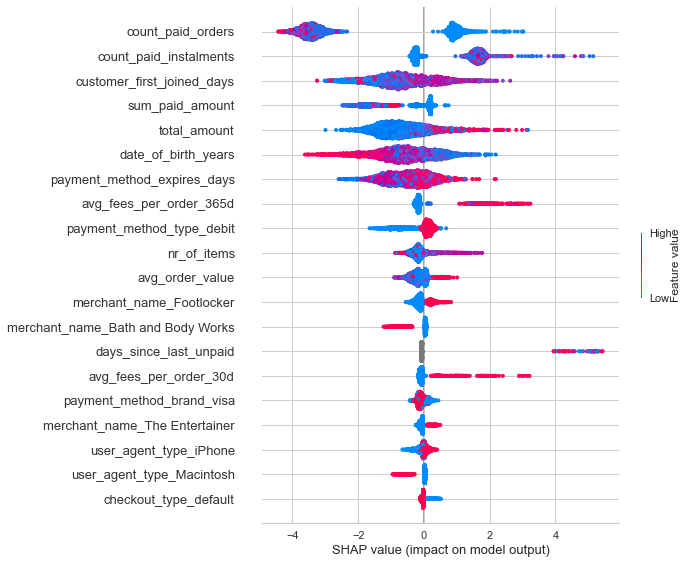

In [59]:
explainer_train = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values_train, X_train_transformed, plot_type="dot")

In [60]:
from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
)

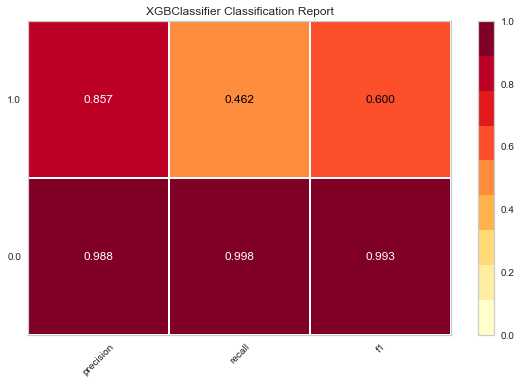

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [61]:
visualizer = ClassificationReport(model)

visualizer.fit(X_train_transformed, y_train)        # Fit the visualizer and the model
visualizer.score(X_test_transformed, y_test)        # Evaluate the model on the test data
visualizer.show() 

In [62]:
print(classification_report(y_test, model.predict(X_test_transformed)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       564
         1.0       0.86      0.46      0.60        13

    accuracy                           0.99       577
   macro avg       0.92      0.73      0.80       577
weighted avg       0.98      0.99      0.98       577



[11:25:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:25:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


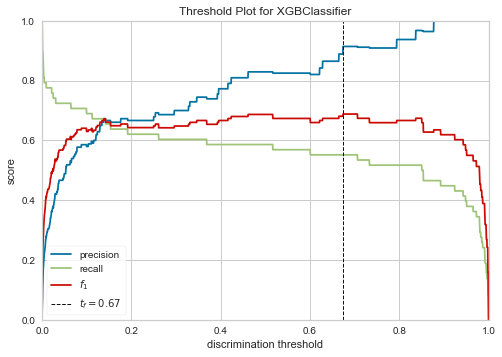

<AxesSubplot:title={'center':'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [63]:
visualizer = DiscriminationThreshold(model,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train_transformed, y_train)        # Fit the visualizer and the model
visualizer.score(X_test_transformed, y_test)        # Evaluate the model on the test data
visualizer.show()

In [64]:
confusion_matrix(y_test, model.predict(X_test_transformed))

array([[563,   1],
       [  7,   6]])

In [65]:
model.predict_proba(X_test_transformed)

array([[6.6894293e-03, 9.9331057e-01],
       [9.9999112e-01, 8.8963898e-06],
       [9.9995619e-01, 4.3837048e-05],
       ...,
       [9.9547571e-01, 4.5243003e-03],
       [9.6268421e-01, 3.7315793e-02],
       [9.9999356e-01, 6.4530536e-06]], dtype=float32)

In [66]:
thresholds = np.linspace(0, 1, 100)

thresholds

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [67]:
probs = model.predict_proba(X_test_transformed)

In [68]:
fpr_ls = []
fnr_ls = []
tpr_ls = []

for threshold in thresholds:   
    
    # obtain class prediction based on threshold
    preds = np.where(probs>=threshold, 1, 0)[:,1]
    # print(preds)
    
    # obtain confusion matrix
    cm = confusion_matrix(y_test, preds, labels=[0,1])
    print(f"Threshold: {threshold} - ")
    print(cm)

    print(f"The number of true 1: {y_test.sum()}")
    print(f"The number of pred 1: {preds.sum()}")

    print(classification_report(y_test, preds))

    # obtain confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds, labels=[0,1]).ravel()
    
    #  obtain FRP and FNR
    FPR = fp / (tn + fp)
    FNR =  fn / (tp + fn)
    TPR = tp / (fn + tp)

    fpr_ls.append(FPR)
    fnr_ls.append(FNR)
    tpr_ls.append(TPR)

Threshold: 0.0 - 
[[  0 564]
 [  0  13]]
The number of true 1: 13.0
The number of pred 1: 577
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       564
         1.0       0.02      1.00      0.04        13

    accuracy                           0.02       577
   macro avg       0.01      0.50      0.02       577
weighted avg       0.00      0.02      0.00       577

Threshold: 0.010101010101010102 - 
[[529  35]
 [  2  11]]
The number of true 1: 13.0
The number of pred 1: 46
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       564
         1.0       0.24      0.85      0.37        13

    accuracy                           0.94       577
   macro avg       0.62      0.89      0.67       577
weighted avg       0.98      0.94      0.95       577

Threshold: 0.020202020202020204 - 
[[544  20]
 [  3  10]]
The number of true 1: 13.0
The number of pred 1: 30
              precision    recal

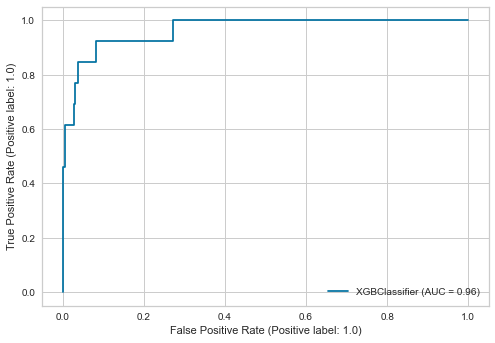

In [69]:
xgb_disp = plot_roc_curve(model, X_test_transformed, y_test)

In [70]:
metrics = pd.concat([
    pd.Series(fpr_ls),
    pd.Series(fnr_ls),
    pd.Series(tpr_ls)
    ], axis=1)

metrics.columns = ['fpr', 'fnr', 'tpr']
metrics.index = thresholds

metrics

,fpr,fnr,tpr
0.000000,1.000000,0.000000,1.000000
0.010101,0.062057,0.153846,0.846154
0.020202,0.035461,0.230769,0.769231
0.030303,0.030142,0.307692,0.692308
0.040404,0.023050,0.384615,0.615385
0.050505,0.023050,0.384615,0.615385
0.060606,0.023050,0.384615,0.615385
0.070707,0.019504,0.384615,0.615385
0.080808,0.019504,0.384615,0.615385
0.090909,0.017730,0.384615,0.615385


In [71]:
y_test.value_counts()

0.0    564
1.0     13
Name: unpaid_at_30, dtype: int64

In [72]:
y_test.sum()

13.0

In [77]:
# score=offset+factor*np.log(prob_good/(1-prob_good))
pdo = 20
factor = pdo/np.log(2)
offset = 600

In [105]:
factor

28.85390081777927

In [107]:
for p in np.arange (0.05, 1, 0.0001):
    print(offset+factor*(np.log((1-p)/p)))

684.9585502688717
684.897862685625
684.8372897381513
684.7768309688483
684.7164859228399
684.6562541479541
684.5961351947025
684.5361286162582
684.4762339684356
684.416450809669
684.3567787009922
684.2972172060186
684.2377658909201
684.1784243244081
684.1191920777129
684.0600687245651
684.001053841175
683.9421470062143
683.8833478007969
683.8246558084593
683.7660706151433
683.7075918091765
683.6492189812543
683.5909517244218
683.5327896340556
683.4747323078466
683.4167793457817
683.358930350127
683.3011849254099
683.2435426784023
683.1860032181037
683.1285661557243
683.0712311046684
683.0139976805181
682.9568655010162
682.8998341860511
682.8429033576402
682.7860726399142
682.7293416591008
682.67271004351
682.6161774235185
682.5597434315534
682.5034077020786
682.4471698715785
682.3910295785438
682.3349864634566
682.2790401687759
682.2231903389227
682.1674366202664
682.1117786611097
682.0562161116754
682.000748624092
681.9453758523797
681.8900974524371
681.8349130820275
681.7798224007652

In [80]:
print(offset+factor*np.log(0.01/(1-0.01)))

467.41286759840784


In [102]:
score = []
for p in model.predict_proba(X_test_transformed)[:,1]:
    score_value = offset+factor*(np.log((1-p)/p))
    score.append(score_value)

In [103]:
min(score)

401.1060850151154

In [104]:
max(score)

1025.6000458694539

In [99]:
len(score)

577

In [100]:
score

[455.7156415297038,
 935.566714741482,
 889.5485315921699,
 860.746997588798,
 897.0102144442911,
 822.8275751052506,
 923.9788545114009,
 882.0753759705003,
 835.2104372386254,
 952.460694508494,
 874.4336511593247,
 857.7902690159968,
 882.7551364439992,
 843.5763873829909,
 826.3843120441663,
 777.2622571821022,
 669.6468371215623,
 869.4615086157892,
 871.7241942123285,
 960.2902521745817,
 831.0277062860885,
 815.9293501232194,
 899.5970263308725,
 879.3247568258515,
 725.5126647819576,
 856.5695252614198,
 882.9232363372712,
 895.8495381760056,
 910.0175500732705,
 981.0839445767539,
 790.3373275173014,
 904.7947273035641,
 777.6675865165612,
 879.8902334440825,
 869.1655325988891,
 879.5678150951235,
 972.7286146826293,
 903.6917821237084,
 918.0892614778281,
 932.2138780419114,
 826.0847337292005,
 824.2770153698742,
 828.0765132888946,
 839.7491547583672,
 916.1850149072701,
 946.9560655307403,
 941.4059498082192,
 929.090921267694,
 707.4461612633214,
 991.9395462530824,
 841

In [90]:
y_test

9690     1.0
4335     0.0
3743     0.0
7839     0.0
8648     0.0
        ... 
12147    0.0
5957     0.0
9090     1.0
1722     0.0
5599     0.0
Name: unpaid_at_30, Length: 577, dtype: float32

In [113]:
list(model.predict_proba(X_test_transformed)[:,1])

[0.9933106,
 8.89639e-06,
 4.3837048e-05,
 0.00011893645,
 3.3848242e-05,
 0.0004425054,
 1.3293109e-05,
 5.6796016e-05,
 0.00028814096,
 4.9537693e-06,
 7.4016716e-05,
 0.0001317688,
 5.5473687e-05,
 0.00021563358,
 0.00039120702,
 0.0021429178,
 0.082128264,
 8.793504e-05,
 8.1303275e-05,
 3.776502e-06,
 0.00033307486,
 0.00056194694,
 3.094582e-05,
 6.247645e-05,
 0.012743136,
 0.00013746247,
 5.515146e-05,
 3.523753e-05,
 2.15656e-05,
 1.8370217e-06,
 0.0013631553,
 2.584467e-05,
 0.0021130885,
 6.1264036e-05,
 8.884162e-05,
 6.195241e-05,
 2.4539984e-06,
 2.6851685e-05,
 1.6303185e-05,
 9.992601e-06,
 0.0003952883,
 0.0004208349,
 0.00036893185,
 0.0002462117,
 1.7415412e-05,
 5.994987e-06,
 7.2665e-06,
 1.1134821e-05,
 0.02357295,
 1.2610185e-06,
 0.00022808505,
 9.547568e-06,
 0.0007752817,
 3.86843e-06,
 4.5793066e-05,
 0.00022941746,
 2.036732e-05,
 2.8341066e-05,
 8.841962e-05,
 2.3721586e-06,
 1.4862585e-05,
 1.7355625e-05,
 0.00013826898,
 9.968078e-05,
 0.0010390234,
 7.15

In [94]:
9.93310571e-01

0.993310571

In [114]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class ProbabilityToScore(BaseEstimator, TransformerMixin):
    def __init__(self):

        self.pdo = 20  # Points to Double the Odds
        self.factor = self.pdo / np.log(2)
        self.offset = 600  # Base score

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, probabilities_list):

        # if not isinstance(probabilities_list, list):
        #     raise ValueError("probabilities_list should be a list")

        score_tmp = [
            (self.offset + self.factor * (np.log((1 - p) / p)))
            for p in probabilities_list
        ]

        score = 

        return score


In [115]:
sc = ProbabilityToScore()
sc.transform(model.predict_proba(X_test_transformed)[:,1])

[455.7156415297038,
 935.566714741482,
 889.5485315921699,
 860.746997588798,
 897.0102144442911,
 822.8275751052506,
 923.9788545114009,
 882.0753759705003,
 835.2104372386254,
 952.460694508494,
 874.4336511593247,
 857.7902690159968,
 882.7551364439992,
 843.5763873829909,
 826.3843120441663,
 777.2622571821022,
 669.6468371215623,
 869.4615086157892,
 871.7241942123285,
 960.2902521745817,
 831.0277062860885,
 815.9293501232194,
 899.5970263308725,
 879.3247568258515,
 725.5126647819576,
 856.5695252614198,
 882.9232363372712,
 895.8495381760056,
 910.0175500732705,
 981.0839445767539,
 790.3373275173014,
 904.7947273035641,
 777.6675865165612,
 879.8902334440825,
 869.1655325988891,
 879.5678150951235,
 972.7286146826293,
 903.6917821237084,
 918.0892614778281,
 932.2138780419114,
 826.0847337292005,
 824.2770153698742,
 828.0765132888946,
 839.7491547583672,
 916.1850149072701,
 946.9560655307403,
 941.4059498082192,
 929.090921267694,
 707.4461612633214,
 991.9395462530824,
 841

In [123]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class ProbabilityToScore(BaseEstimator, TransformerMixin):
    def __init__(self):

        self.pdo = 20  # Points to Double the Odds
        self.factor = self.pdo / np.log(2)
        self.offset = 600  # Base score

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, probabilities_list):

        # if not isinstance(probabilities_list, list):
        #     raise ValueError("probabilities_list should be a list")

        score_tmp = [
            (self.offset + self.factor * (np.log((1 - p) / p)))
            for p in probabilities_list
        ]

        score = np.clip(score_tmp, 300, 850)

        return score



In [125]:
sc = ProbabilityToScore()
score = sc.transform(model.predict_proba(X_test_transformed)[:,1])

In [126]:
min(score)

401.1060850151154

In [127]:
max(score)

850.0